# 🧪 DFT Workshop (Python) — A Minimal Gaussian-Basis Code for Hydrogen (Part I) and Helium with LDA Exchange (Part II)

This notebook builds a compact **Gaussian-basis electronic-structure code** in Python, organized **routine by routine**.

- **Part I (Hydrogen, 1 electron):** Gaussian basis, analytic integrals, matrix representation, generalized eigenvalue problem, and density matrix.
- **Part II (Helium, 2 electrons):** a genuinely **self-consistent** (density-dependent) problem, including **LDA exchange** built from the density on a radial grid.

Along the way, short **Python notation boxes** explain how each equation maps to code.


## Learning goals

### Physics / DFT
- Build the one-electron operator $\hat h = -\tfrac12\nabla^2 - \tfrac{Z}{r}$ in a Gaussian basis.
- Assemble and interpret the matrices $\mathbf{S}$, $\mathbf{T}$, $\mathbf{V}^{\mathrm{ne}}$, and $\mathbf{h}=\mathbf{T}+\mathbf{V}^{\mathrm{ne}}$.
- Solve the generalized eigenvalue problem $\mathbf{h}\mathbf{C}=\mathbf{S}\mathbf{C}\boldsymbol{\varepsilon}$ and reconstruct orbitals and densities.
- For Helium, run a true SCF loop and add an LDA exchange contribution from the density.

### Python / scientific computing
- Translate equations into small functions with clear inputs and outputs.
- Use NumPy for arrays/linear algebra, Pandas for tables, Matplotlib for plots, and ipywidgets for interactivity.


## Notebook roadmap

### Part I — Hydrogen (foundations)
- Define the Boys function $F_0(T)$ and the Gaussian normalization $N(\alpha)$
- Interactive: explore a **single primitive Gaussian** by changing $\alpha$ and the coefficient
- Define an uncontracted Gaussian basis (a list of primitive s-type Gaussians)
- Interactive: explore a **basis expansion** $\phi(r)=\sum_\mu C_\mu \chi_\mu(r)$ with 6 Gaussians
- Implement primitive integrals and build $\mathbf{S}$, $\mathbf{T}$, $\mathbf{V}^{\mathrm{ne}}$, and $\mathbf{h}$
- Derive and implement the generalized eigenvalue solver
- Solve for Hydrogen, visualize $\psi(r)$ and $n(r)$, and analyze basis quality

### Part II — Helium (real SCF + LDA-x)
- Define the Helium problem ($Z=2$), closed-shell occupations, and the density matrix $\mathbf{P}$
- Implement ERIs and the Hartree matrix $\mathbf{J}[\mathbf{P}]$
- Implement LDA exchange ($\varepsilon_x(n)$, $v_x(n)$) and the exchange matrix $\mathbf{V}_x$
- Run the SCF cycle and compare Hartree-only vs Hartree + LDA-x


## Equation to be solved (Kohn–Sham viewpoint and one-electron limit)

For a one-electron atom (Hydrogen, $Z=1$), the Kohn–Sham equation can be written as
$$
\left[
-\frac{1}{2}\nabla^2
-\frac{Z}{r}
+ v_H[n](\mathbf r)
+ v_{xc}[n](\mathbf r)
\right]\phi(\mathbf r)
=
\varepsilon \phi(\mathbf r).
$$

### One-electron limit (Hydrogen)
For a one-electron system, the exact exchange-correlation term cancels the self-Coulomb (Hartree) term:
$$
v_{xc}[n](\mathbf r) = -v_H[n](\mathbf r).
$$

Therefore, the exact one-electron problem reduces to the Schrödinger equation
$$
\left[-\frac{1}{2}\nabla^2 - \frac{1}{r}\right]\phi(\mathbf r)
= \varepsilon \phi(\mathbf r),
$$
with exact ground-state energy
$$
E_{\mathrm{exact}} = -0.5\ \text{Hartree}.
$$


## Routine 01 — Import Libraries and Define Numerical Helpers


### Python / scientific libraries used in this notebook

- `math`: elementary functions in analytic formulas (`sqrt`, `exp`, `erf`).
- `numpy` (`np`): arrays, vectorized math, linear algebra.
- `pandas` (`pd`): tables for summaries (basis comparison, SCF history).
- `matplotlib.pyplot` (`plt`): plotting.

**First NumPy function used**
- `np.set_printoptions(...)`: controls how NumPy arrays are printed (precision, scientific notation).


### Python notation box — imports and aliases

**What the code does**
- `import numpy as np` imports NumPy and assigns the short alias `np` (standard scientific-Python style).
- `import pandas as pd` imports Pandas and assigns `pd` for tables.
- `import matplotlib.pyplot as plt` imports Matplotlib plotting functions under the alias `plt`.
- `np.set_printoptions(...)` configures how NumPy arrays are printed (useful for inspecting matrices).


### Implementation: import the scientific stack

The next code cell imports the libraries used throughout the notebook and sets NumPy print options for readability.


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, suppress=True)


## Routine 02 — Define the Boys Function and Gaussian Normalization

We use the **Boys function** $F_0(T)$, which appears in nuclear attraction and two-electron Gaussian integrals:

$$
F_0(T) = \int_0^1 e^{-T u^2}\,du
=
\frac{1}{2}\sqrt{\frac{\pi}{T}}\,\mathrm{erf}(\sqrt{T}) \quad (T>0).
$$

Near $T=0$, we use a small-$T$ series for numerical stability.

For an s-type primitive Gaussian
$$
g_\alpha(\mathbf r)=N(\alpha)e^{-\alpha r^2},
$$
the normalization constant is
$$
N(\alpha)=\left(\frac{2\alpha}{\pi}\right)^{3/4}.
$$


### Python notation box — Boys function and Gaussian normalization

**Equation → code mapping**
- $F_0(T)$ → `boys0(T)`
- $N(\alpha)=\left(\frac{2\alpha}{\pi}\right)^{3/4}$ → `norm_s(alpha)`

**Programming notes**
- `if T < 1e-10:` uses a stable series expansion near $T=0$.
- `math.erf(x)` is the error function $\mathrm{erf}(x)$.
- `math.exp(x)` and `math.sqrt(x)` implement $e^x$ and $\sqrt{x}$.


### Implementation: `boys0(T)` and `norm_s(alpha)`

**What the code does**
- defines the special function $F_0(T)$ used in Gaussian integrals (with a stable small-$T$ branch),
- defines the s-type Gaussian normalization constant $N(\alpha)$,
- returns plain Python floats, so these helpers can be used inside integral routines.


In [2]:
def boys0(T):
    """
    Boys function F0(T), stable near T=0.
    """
    T = float(T)
    if T < 1e-10:
        return 1.0 - T/3.0 + T*T/10.0
    return 0.5 * math.sqrt(math.pi / T) * math.erf(math.sqrt(T))


def norm_s(alpha):
    """
    Normalization constant for a primitive s-type Gaussian:
        g(r) = N(alpha) exp(-alpha r^2)
    """
    return (2.0 * alpha / math.pi) ** 0.75


for a in [0.1, 1.0, 5.0]:
    print(f"alpha={a:5.2f} -> N={norm_s(a):.6f}")
print("boys0(0) ≈", boys0(0.0))


alpha= 0.10 -> N=0.126739
alpha= 1.00 -> N=0.712705
alpha= 5.00 -> N=2.383074
boys0(0) ≈ 1.0


## Routine 03 — Interactive: explore a primitive Gaussian

A normalized s-type primitive Gaussian centered at the origin is
$$
\chi(r) = c\,N(\alpha)\,e^{-\alpha r^2},
\qquad
N(\alpha)=\left(\frac{2\alpha}{\pi}\right)^{3/4}.
$$

Use the sliders below to see how:
- $\alpha$ controls the width (diffuse vs tight),
- the coefficient $c$ scales the amplitude.


### Python notation box — interactive Gaussian

**Equation → code mapping**
- $\alpha$ → `alpha`
- coefficient $c$ → `coeff`
- $\chi(r)$ → `chi_r`

**Programming notes**
- `widgets.FloatLogSlider` is convenient for parameters spanning orders of magnitude (like $\alpha$).
- The plot is updated by a callback function whenever a slider changes.


### Implementation: interactive plot with ipywidgets

The next cell:
- builds an `r` grid with `np.linspace`,
- computes $\chi(r)$ for the chosen parameters,
- updates a Matplotlib plot when sliders are moved.


In [3]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

r = np.linspace(0.0, 5.0, 400)

alpha_slider = widgets.FloatLogSlider(
    value=1.0, base=10, min=-2, max=2, step=0.01,
    description=r'$\alpha$',
    continuous_update=True,
    readout_format='.3g'
)

coeff_slider = widgets.FloatSlider(
    value=1.0, min=-2.0, max=2.0, step=0.05,
    description=r'$c$',
    continuous_update=True
)

out = widgets.Output()

def plot_primitive(alpha, coeff):
    with out:
        out.clear_output(wait=True)
        chi_r = coeff * norm_s(alpha) * np.exp(-alpha * r**2)
        plt.figure(figsize=(6, 4))
        plt.plot(r, chi_r)
        plt.xlabel("r (bohr)")
        plt.ylabel(r"$\chi(r)$")
        plt.title("Primitive Gaussian: $c\,N(\\alpha)e^{-\\alpha r^2}$")
        plt.grid(True)
        plt.show()

ui = widgets.HBox([alpha_slider, coeff_slider])
display(ui, out)

def _update(change=None):
    plot_primitive(alpha_slider.value, coeff_slider.value)

alpha_slider.observe(_update, names="value")
coeff_slider.observe(_update, names="value")

_update()


Output()

## Routine 04 — Define Gaussian Basis Functions (uncontracted s-type primitives)

### Basis expansion
The orbital is expanded as
$$
\phi(\mathbf r)=\sum_\mu C_\mu \chi_\mu(\mathbf r).
$$

In this notebook, each basis function $\chi_\mu$ is an **s-type primitive Gaussian** centered at the nucleus:
$$
\chi_\mu(\mathbf r)=N(\alpha_\mu)\,e^{-\alpha_\mu r^2}.
$$

A Gaussian basis set is represented by a list of exponents $\{\alpha_\mu\}$.


### Python notation box — basis functions stored as dictionaries

**Equation → code mapping**
- basis function $\chi_\mu$ → `basis[mu]` (a dictionary)
- primitive list $\{(\alpha, d)\}$ → `basis[mu]["primitives"]`
- center $\mathbf A$ → `basis[mu]["center"]`
- label → `basis[mu]["label"]`

**Programming notes**
- A basis is a Python list; `len(basis)` is the number of Gaussians.
- `pd.DataFrame(...)` displays basis parameters as a readable table.


### Implementation: build the basis and inspect parameters

**What the code does**
- constructs a Python list `basis` where each entry stores one Gaussian basis function,
- stores basis-function metadata as a dictionary (`label`, `center`, `primitives`),
- prints the chosen exponent set in a readable Pandas table.


In [4]:
ORIGIN = np.array([0.0, 0.0, 0.0])

def primitive_basis_from_exponents(exponents, center=ORIGIN, label_prefix="g"):
    """
    Build an uncontracted basis: one primitive Gaussian per basis function.

    Data structure:
      basis[mu] is a dictionary with
        - "label": string
        - "center": 3D NumPy array
        - "primitives": list of (alpha, coeff)
    """
    basis = []
    for i, alpha in enumerate(exponents, start=1):
        basis.append({
            "label": f"{label_prefix}{i}",
            "center": np.array(center, dtype=float),
            "primitives": [(float(alpha), 1.0)],  # (alpha, coefficient)
        })
    return basis


def describe_basis(basis):
    """
    Convert the basis dictionaries into a Pandas table for inspection.
    """
    rows = []
    for mu, bf in enumerate(basis):
        for p, (alpha, coeff) in enumerate(bf["primitives"], start=1):
            rows.append({
                "mu": mu,
                "label": bf["label"],
                "primitive": p,
                "alpha": alpha,
                "coeff": coeff,
                "center_x": bf["center"][0],
                "center_y": bf["center"][1],
                "center_z": bf["center"][2],
            })
    return pd.DataFrame(rows)


# Main workshop basis (6 primitive Gaussians: diffuse -> tight)
exponents_demo = [0.05, 0.15, 0.5, 1.5, 4.5, 13.5]
basis = primitive_basis_from_exponents(exponents_demo)

display(describe_basis(basis))


,mu,label,primitive,alpha,coeff,center_x,center_y,center_z
0,0,g1,1,0.05,1.0,0.0,0.0,0.0
1,1,g2,1,0.15,1.0,0.0,0.0,0.0
2,2,g3,1,0.50,1.0,0.0,0.0,0.0
3,3,g4,1,1.50,1.0,0.0,0.0,0.0
4,4,g5,1,4.50,1.0,0.0,0.0,0.0
5,5,g6,1,13.50,1.0,0.0,0.0,0.0


### How the code represents the basis parameters

For each primitive Gaussian:

- **Exponent** $\alpha$: controls the width  
  - small $\alpha$ → diffuse (long-range)  
  - large $\alpha$ → tight (localized)

- **Primitive coefficient** $d$: multiplicative weight stored alongside $\alpha$.  
  In this notebook, the primitive coefficient is set to $d=1$ for all basis functions, but the data structure keeps $d$ explicit so it can be extended later.

Using multiple exponents in the same basis provides flexibility to represent the Hydrogen $1s$ orbital near the nucleus and in the tail region.


## Routine 05 — Interactive: explore a Gaussian basis expansion

A basis expansion (radial, s-type) is
$$
\phi(r)=\sum_{\mu=1}^{M} C_\mu\,\chi_\mu(r),
\qquad
\chi_\mu(r)=N(\alpha_\mu)\,e^{-\alpha_\mu r^2}.
$$

Use the sliders to change:
- the exponents $\alpha_\mu$ (shape of each basis function),
- the coefficients $C_\mu$ (linear-combination weights).

This is a direct preview of what the eigenvalue problem will determine automatically later.


### Python notation box — interactive basis expansion

**Equation → code mapping**
- $M$ → `M` (here `M=6`)
- exponents $\{\alpha_\mu\}$ → `alphas` (list of length `M`)
- coefficients $\{C_\mu\}$ → `C` (list of length `M`)
- $\phi(r)$ → `phi_r`

**Programming notes**
- The basis functions are evaluated vectorized on a grid `r`.
- The expansion is a weighted sum: `phi_r = sum(C[mu] * chi_mu_r)`.


### Implementation: ipywidgets controls for 6 Gaussians

The next cell creates:
- 6 sliders for $\alpha_\mu$ (log scale),
- 6 sliders for $C_\mu$ (linear scale),
and updates the plot of $\phi(r)$ in real time.


In [5]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

r = np.linspace(0.0, 6.0, 500)
M = 6

alpha_sliders = [
    widgets.FloatLogSlider(value=exponents_demo[i], base=10, min=-2, max=2, step=0.01,
                           description=fr'$\alpha_{i+1}$', continuous_update=True, readout_format='.3g')
    for i in range(M)
]

C_sliders = [
    widgets.FloatSlider(value=1.0 if i==0 else 0.0, min=-2.0, max=2.0, step=0.05,
                        description=fr'$C_{i+1}$', continuous_update=True)
    for i in range(M)
]

out2 = widgets.Output()

def plot_basis_expansion(alphas, C):
    with out2:
        out2.clear_output(wait=True)
        phi_r = np.zeros_like(r)
        for mu in range(M):
            phi_r += C[mu] * norm_s(alphas[mu]) * np.exp(-alphas[mu] * r**2)
        plt.figure(figsize=(6, 4))
        plt.plot(r, phi_r, label=r'$\phi(r)$')
        plt.xlabel("r (bohr)")
        plt.ylabel(r"$\phi(r)$")
        plt.title(r"Basis expansion: $\phi(r)=\sum_\mu C_\mu N(\alpha_\mu)e^{-\alpha_\mu r^2}$")
        plt.grid(True)
        plt.legend()
        plt.show()

def _update2(change=None):
    alphas = [w.value for w in alpha_sliders]
    C = [w.value for w in C_sliders]
    plot_basis_expansion(alphas, C)

for w in alpha_sliders + C_sliders:
    w.observe(_update2, names="value")

controls = widgets.VBox([
    widgets.HTML("<b>Exponents (log scale)</b>"),
    widgets.VBox(alpha_sliders),
    widgets.HTML("<b>Coefficients</b>"),
    widgets.VBox(C_sliders),
])
display(controls, out2)
_update2()


Output()

## Routine 06 — Build the matrix representations $\mathbf{S}$, $\mathbf{T}$, $\mathbf{V}^{\mathrm{ne}}$, and $\mathbf{h}$

Using the Gaussian basis $\{\chi_\mu\}$, we build:

- **Overlap**
$$
S_{\mu\nu} = \langle \chi_\mu | \chi_\nu \rangle
$$

- **Kinetic**
$$
T_{\mu\nu} = \left\langle \chi_\mu \left| -\frac12 \nabla^2 \right| \chi_\nu \right\rangle
$$

- **Electron–nucleus attraction**
$$
V^{\mathrm{ne}}_{\mu\nu} =
\left\langle \chi_\mu \left| -\frac{Z}{r} \right| \chi_\nu \right\rangle
$$

and the core one-electron matrix
$$
\mathbf{h}=\mathbf{T}+\mathbf{V}^{\mathrm{ne}}.
$$


### Python notation box — core matrices

**Equation → code mapping**
- $S_{\mu\nu}$ → `S[mu, nu]`
- $T_{\mu\nu}$ → `T[mu, nu]`
- $V^{\mathrm{ne}}_{\mu\nu}$ → `Vne[mu, nu]`
- $h_{\mu\nu}$ → `h[mu, nu] = T + Vne`

**Programming notes**
- `mu` and `nu` are integer indices over basis functions (`0 ... n-1`).
- Each matrix is allocated with `np.zeros((n, n))` and filled in nested loops.


### Implementation: primitive integrals and matrix builders

The next cell defines:
- analytic **primitive** integrals for s-type Gaussians (overlap, kinetic, electron–nucleus),
- matrix builders that sum over primitives inside each basis function.

These functions are then used to assemble `S`, `T`, `Vne`, and `h` for the chosen basis.


In [6]:
# Primitive s-type integrals (used to build S, T, Vne)

def overlap_ss(alpha, beta, A, B):
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    p = alpha + beta
    mu = alpha * beta / p
    R2 = np.dot(A - B, A - B)
    return norm_s(alpha) * norm_s(beta) * (math.pi / p) ** 1.5 * math.exp(-mu * R2)


def kinetic_ss(alpha, beta, A, B):
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    p = alpha + beta
    mu = alpha * beta / p
    R2 = np.dot(A - B, A - B)
    return (
        norm_s(alpha) * norm_s(beta)
        * mu * (3.0 - 2.0 * mu * R2)
        * (math.pi / p) ** 1.5
        * math.exp(-mu * R2)
    )


def nuclear_attraction_ss(alpha, beta, A, B, C, Z=1.0):
    """
    Primitive nuclear attraction integral:
        <a| -Z/|r-C| |b>
    """
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    C = np.asarray(C, dtype=float)

    p = alpha + beta
    mu = alpha * beta / p
    RAB2 = np.dot(A - B, A - B)
    P = (alpha * A + beta * B) / p
    RPC2 = np.dot(P - C, P - C)

    return (
        -Z
        * norm_s(alpha) * norm_s(beta)
        * (2.0 * math.pi / p)
        * math.exp(-mu * RAB2)
        * boys0(p * RPC2)
    )

# Matrix builders (sum over primitives inside each basis function)

# Helper functions: core matrices and generalized eigenproblem

def basis_overlap_matrix(basis):
    n = len(basis)
    S = np.zeros((n, n), dtype=float)
    for mu, bmu in enumerate(basis):
        for nu, bnu in enumerate(basis):
            val = 0.0
            for alpha, dmu in bmu["primitives"]:
                for beta, dnu in bnu["primitives"]:
                    val += dmu * dnu * overlap_ss(alpha, beta, bmu["center"], bnu["center"])
            S[mu, nu] = val
    return S

def basis_kinetic_matrix(basis):
    n = len(basis)
    T = np.zeros((n, n), dtype=float)
    for mu, bmu in enumerate(basis):
        for nu, bnu in enumerate(basis):
            val = 0.0
            for alpha, dmu in bmu["primitives"]:
                for beta, dnu in bnu["primitives"]:
                    val += dmu * dnu * kinetic_ss(alpha, beta, bmu["center"], bnu["center"])
            T[mu, nu] = val
    return T

def basis_nuclear_matrix(basis, Z=1.0, C=ORIGIN):
    n = len(basis)
    Vne = np.zeros((n, n), dtype=float)
    for mu, bmu in enumerate(basis):
        for nu, bnu in enumerate(basis):
            val = 0.0
            for alpha, dmu in bmu["primitives"]:
                for beta, dnu in bnu["primitives"]:
                    val += dmu * dnu * nuclear_attraction_ss(alpha, beta, bmu["center"], bnu["center"], C, Z=Z)
            Vne[mu, nu] = val
    return Vne

def core_hamiltonian(basis, Z=1.0, C=ORIGIN):
    S = basis_overlap_matrix(basis)
    T = basis_kinetic_matrix(basis)
    Vne = basis_nuclear_matrix(basis, Z=Z, C=C)
    h = T + Vne
    return S, T, Vne, h


In [7]:

# Matrix construction using the helper functions defined above
S, T, Vne, h = core_hamiltonian(basis, Z=1.0, C=ORIGIN)

print("Basis dimension =", len(basis))

print("\nOverlap matrix S:")
print(S)

print("\nKinetic matrix T:")
print(T)

print("\nNuclear-attraction matrix Vne:")
print(Vne)

print("\nCore Hamiltonian h = T + Vne:")
print(h)

Basis dimension = 6

Overlap matrix S:
[[1.       0.805927 0.435969 0.21006  0.095206 0.042229]
 [0.805927 1.       0.773519 0.435969 0.21006  0.095206]
 [0.435969 0.773519 1.       0.805927 0.464758 0.226116]
 [0.21006  0.435969 0.805927 1.       0.805927 0.464758]
 [0.095206 0.21006  0.464758 0.805927 1.       0.805927]
 [0.042229 0.095206 0.226116 0.464758 0.805927 1.      ]]

Kinetic matrix T:
[[ 0.075     0.090667  0.05945   0.030493  0.014124  0.006311]
 [ 0.090667  0.225     0.267757  0.178351  0.091478  0.042372]
 [ 0.05945   0.267757  0.75      0.906668  0.627423  0.32706 ]
 [ 0.030493  0.178351  0.906668  2.25      2.720005  1.88227 ]
 [ 0.014124  0.091478  0.627423  2.720005  6.75      8.160015]
 [ 0.006311  0.042372  0.32706   1.88227   8.160015 20.25    ]]

Nuclear-attraction matrix Vne:
[[-0.356825 -0.406692 -0.364832 -0.295097 -0.229153 -0.175404]
 [-0.406692 -0.618039 -0.703692 -0.631907 -0.511122 -0.396905]
 [-0.364832 -0.703692 -1.128379 -1.286074 -1.172646 -0.954662]

## Routine 07 — Derive and implement the generalized eigenvalue problem

### What problem are we solving?

In a non‑orthonormal Gaussian basis, the one‑electron eigenproblem is **generalized**:
$$
\mathbf{h}\,\mathbf{C}=\mathbf{S}\,\mathbf{C}\,\boldsymbol{\varepsilon}.
$$

**Meanings and shapes**
- $\mathbf{S}$: **overlap matrix**, $S_{\mu\nu}=\langle\chi_\mu|\chi_\nu\rangle$ (shape: $n\times n$)
- $\mathbf{h}$: **Hamiltonian matrix** in the basis, $h_{\mu\nu}=\langle\chi_\mu|\hat h|\chi_\nu\rangle$ (shape: $n\times n$)  
  (Many textbooks write this as $\mathbf{H}$; here we use $\mathbf{h}$ for the one‑electron “core” operator.)
- $\mathbf{C}$: **coefficient matrix** (shape: $n\times n$). Column $i$ contains the coefficients of orbital $i$:
  $$
  \phi_i(\mathbf r)=\sum_\mu C_{\mu i}\,\chi_\mu(\mathbf r).
  $$
- $\boldsymbol{\varepsilon}$: **diagonal matrix of eigenvalues** (shape: $n\times n$), with entries $\varepsilon_i$.

### Why is this not a standard eigenvalue problem?

If the basis were orthonormal, $\mathbf{S}=\mathbf{I}$ and the equation would reduce to:
$$
\mathbf{h}\mathbf{C}=\mathbf{C}\boldsymbol{\varepsilon}.
$$
But for Gaussians, $\mathbf{S}\neq\mathbf{I}$, so we need a method that respects the overlap matrix.

### Step-by-step solution (symmetric orthogonalization)

A stable approach is **symmetric orthogonalization**:

1. Diagonalize the overlap:
   $$
   \mathbf{S}=\mathbf{U}\,\mathbf{s}\,\mathbf{U}^\mathsf{T},
   $$
   where $\mathbf{s}$ is diagonal (eigenvalues of $\mathbf{S}$).

2. Build the inverse square root:
   $$
   \mathbf{X}=\mathbf{S}^{-1/2}=\mathbf{U}\,\mathbf{s}^{-1/2}\,\mathbf{U}^\mathsf{T}.
   $$

3. Transform the Hamiltonian to an orthonormal basis:
   $$
   \tilde{\mathbf{h}}=\mathbf{X}^\mathsf{T}\,\mathbf{h}\,\mathbf{X}.
   $$

4. Solve the **standard** symmetric eigenproblem:
   $$
   \tilde{\mathbf{h}}\,\mathbf{C}'=\mathbf{C}'\,\boldsymbol{\varepsilon}.
   $$

5. Back‑transform the eigenvectors to the original basis:
   $$
   \mathbf{C}=\mathbf{X}\,\mathbf{C}'.
   $$

The code below implements these steps.


### Python notation box — generalized eigenproblem

**Equation → code mapping**
- overlap matrix $\mathbf{S}$ → `S`
- Hamiltonian matrix $\mathbf{h}$ → `h`
- eigenvalues $\varepsilon_i$ → `eps[i]`
- coefficient matrix $\mathbf{C}$ → `C`  (columns are eigenvectors / orbitals)
- orthogonalizer $\mathbf{X}=\mathbf{S}^{-1/2}$ → `X`

**Programming notes**
- `np.linalg.eigh(A)` diagonalizes a **symmetric** matrix and returns eigenvalues/eigenvectors.
- The symmetric orthogonalization approach ensures numerical stability because it avoids forming $\mathbf{S}^{-1}\mathbf{h}$ directly.
- After solving, `C[:, i]` is the coefficient vector for orbital `i` in the original (non‑orthonormal) basis.

**First-time functions (if new to students)**
- `np.linalg.eigh(A)`: eigenvalues and eigenvectors of a symmetric matrix.


### Implementation: symmetric orthogonalization solver

The next cell defines:
- `symmetric_orthogonalization(S)` to build $\mathbf{S}^{-1/2}$,
- `solve_generalized_eigenproblem(h, S)` that returns `(eps, C)`.


In [8]:
def symmetric_orthogonalization(S):
    eigvals, eigvecs = np.linalg.eigh(S)
    if np.any(eigvals < 1e-10):
        raise ValueError("Overlap matrix has near-linear dependence. Adjust basis exponents.")
    return eigvecs @ np.diag(eigvals**-0.5) @ eigvecs.T

def solve_generalized_eigenproblem(F, S):
    X = symmetric_orthogonalization(S)
    F_ortho = X.T @ F @ X
    eps, C_tilde = np.linalg.eigh(F_ortho)
    C = X @ C_tilde
    return eps, C


In [9]:
# Solve the generalized eigenvalue problem h C = S C eps
eps_core, C_core = solve_generalized_eigenproblem(h, S)

print("Orbital energies from the core Hamiltonian:", eps_core)
print("Lowest variational estimate:", eps_core[0], "Hartree")
print("Exact Hydrogen energy:", -0.5, "Hartree")


Orbital energies from the core Hamiltonian: [-0.499486 -0.10363   0.397462  2.494975  9.904101 34.941494]
Lowest variational estimate: -0.49948583080305825 Hartree
Exact Hydrogen energy: -0.5 Hartree


## Routine 08 — Solve for Hydrogen and analyze basis quality

With the chosen basis, we solve the ground state and compare with the exact Hydrogen result:
$$
E_{\mathrm{exact}}=-0.5\ \text{Hartree}.
$$

We perform two complementary checks:

1. **Energy check (variational):** the lowest eigenvalue should approach $-0.5$ Hartree as the basis improves.
2. **Shape check:** compare the numerical $\psi(r)$ and density $n(r)=|\psi(r)|^2$ with the exact $1s$ orbital
$$
\psi_{1s}(r)=\frac{1}{\sqrt{\pi}}e^{-r}.
$$


### Python notation box — solving and diagnostics

**Equation → code mapping**
- orbital coefficients for the ground state → `C[:, 0]`
- numerical orbital on a grid → `phi_num`
- density on a grid → `rho_num = |phi_num|^2`

**Programming notes**
- The orbital is evaluated on a radial grid with vectorized NumPy operations.
- Diagnostic plots use Matplotlib (`plt.plot`, `plt.legend`, `plt.show`).


### Implementation: evaluate the orbital on a grid and compare basis sets

The next cells:
- define helper functions to evaluate Gaussians and orbitals on a radial grid,
- plot $\psi(r)$ and $n(r)$ for the chosen basis,
- compare the variational energy for 1-, 3-, and 6-Gaussian bases.


In [10]:
# Helper functions: radial evaluation of basis/orbitals

def primitive_s_value(alpha, r):
    return norm_s(alpha) * np.exp(-alpha * np.asarray(r, dtype=float)**2)

def basis_function_value(bf, r):
    r = np.asarray(r, dtype=float)
    val = np.zeros_like(r)
    for alpha, coeff in bf["primitives"]:
        val += coeff * primitive_s_value(alpha, r)
    return val

def orbital_value_radial(basis, C, mo_index, r):
    r = np.asarray(r, dtype=float)
    vals = np.zeros_like(r)
    for mu, bf in enumerate(basis):
        vals += C[mu, mo_index] * basis_function_value(bf, r)
    return vals


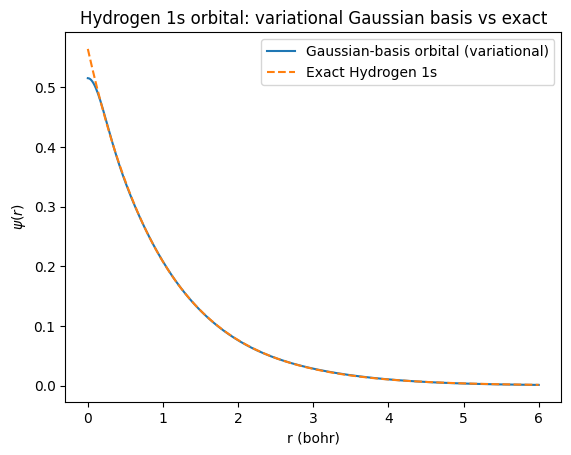

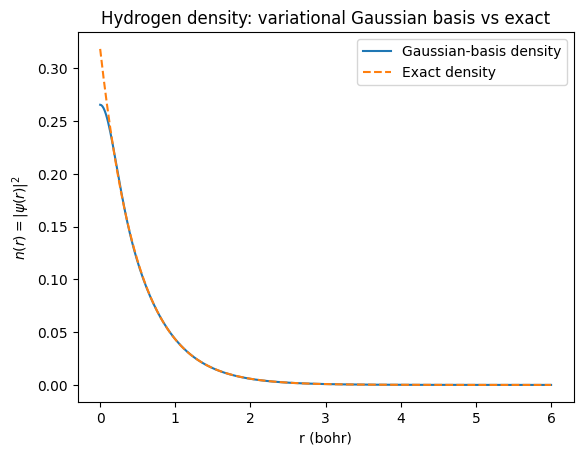

Lowest variational energy (this basis): -0.49948583080305825 Hartree
Exact Hydrogen energy: -0.5 Hartree


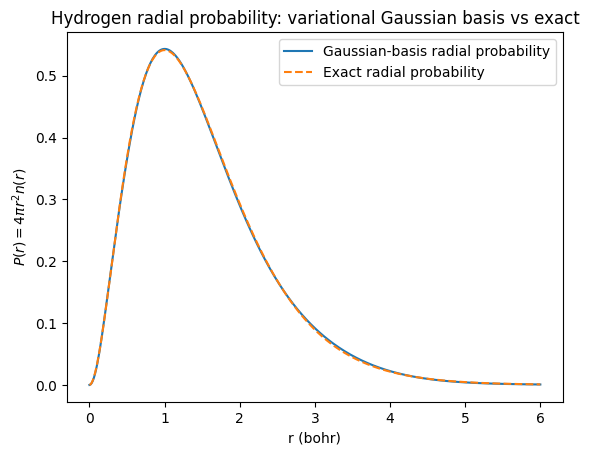

Most probable radius (numerical): 1.007518796992481 bohr
Most probable radius (exact): 1.007518796992481 bohr  (expected ~ 1 bohr)


In [11]:
# Build the one-electron matrix problem and use the lowest eigenstate
S_plot, T_plot, Vne_plot, h_plot = core_hamiltonian(basis, Z=1.0, C=ORIGIN)
eps_plot, C_plot = solve_generalized_eigenproblem(h_plot, S_plot)

r = np.linspace(0.0, 6.0, 400)
phi_num = orbital_value_radial(basis, C_plot, 0, r)
phi_exact = (1.0 / np.sqrt(np.pi)) * np.exp(-r)

rho_num = np.abs(phi_num) ** 2
rho_exact = np.abs(phi_exact) ** 2

plt.figure()
plt.plot(r, phi_num, label="Gaussian-basis orbital (variational)")
plt.plot(r, phi_exact, "--", label="Exact Hydrogen 1s")
plt.xlabel("r (bohr)")
plt.ylabel(r"$\psi(r)$")
plt.title("Hydrogen 1s orbital: variational Gaussian basis vs exact")
plt.legend()
plt.show()

plt.figure()
plt.plot(r, rho_num, label="Gaussian-basis density")
plt.plot(r, rho_exact, "--", label="Exact density")
plt.xlabel("r (bohr)")
plt.ylabel(r"$n(r)=|\psi(r)|^2$")
plt.title("Hydrogen density: variational Gaussian basis vs exact")
plt.legend()
plt.show()

print("Lowest variational energy (this basis):", float(eps_plot[0]), "Hartree")
print("Exact Hydrogen energy:", -0.5, "Hartree")

# Radial probability distribution:
#   P(r) dr = 4π r^2 n(r) dr
# This is the quantity whose maximum occurs near r = a0 for the Hydrogen 1s state.
P_num = 4.0 * np.pi * (r**2) * rho_num
P_exact = 4.0 * np.pi * (r**2) * rho_exact

plt.figure()
plt.plot(r, P_num, label="Gaussian-basis radial probability")
plt.plot(r, P_exact, "--", label="Exact radial probability")
plt.xlabel("r (bohr)")
plt.ylabel(r"$P(r)=4\pi r^2 n(r)$")
plt.title("Hydrogen radial probability: variational Gaussian basis vs exact")
plt.legend()
plt.show()

print("Most probable radius (numerical):", float(r[np.argmax(P_num)]), "bohr")
print("Most probable radius (exact):", float(r[np.argmax(P_exact)]), "bohr  (expected ~ 1 bohr)")


In [12]:
def run_and_summarize_one_electron(basis_local, label):
    S_loc, T_loc, Vne_loc, h_loc = core_hamiltonian(basis_local, Z=1.0, C=ORIGIN)
    eps_loc, C_loc = solve_generalized_eigenproblem(h_loc, S_loc)
    return {
        "basis_label": label,
        "n_basis": len(basis_local),
        "E0_Ha": float(eps_loc[0]),
    }

basis_single = primitive_basis_from_exponents([0.5], label_prefix="single")
basis_small  = primitive_basis_from_exponents([0.15, 0.5, 1.5], label_prefix="u")
basis_big    = primitive_basis_from_exponents([0.05, 0.15, 0.5, 1.5, 4.5, 13.5], label_prefix="u")

summary = pd.DataFrame([
    run_and_summarize_one_electron(basis_single, "1 primitive Gaussian"),
    run_and_summarize_one_electron(basis_small,  "3 primitive Gaussians"),
    run_and_summarize_one_electron(basis_big,    "6 primitive Gaussians (main workshop basis)"),
])

display(summary.sort_values("E0_Ha"))
print("Exact Hydrogen ground-state energy:", -0.5, "Hartree")


,basis_label,n_basis,E0_Ha
2,6 primitive Gaussians (main workshop basis),6,-0.499486
1,3 primitive Gaussians,3,-0.490309
0,1 primitive Gaussian,1,-0.378379


Exact Hydrogen ground-state energy: -0.5 Hartree


### Occupied orbitals vs all computed orbitals (how to read **C**)

When the basis has size **n**, the generalized eigenproblem returns **n orbitals**:

- **C** is an **n × n** matrix.
- Column *i* (i.e., **C[:, i]**) contains the coefficients of orbital *i* in the Gaussian basis:
  $$
  \phi_i(\mathbf r)=\sum_{\mu=1}^{n} C_{\mu i}\,\chi_\mu(\mathbf r).
  $$

However, **not all orbitals are occupied**. Occupations are determined by the electron count:

- Hydrogen: $N_e=1$ → occupy the lowest orbital with $f_0=1$ (others 0)
- Helium (closed shell): $N_e=2$ → occupy the lowest spatial orbital with $f_0=2$ (others 0)

In general (closed shell), orbitals are filled from the lowest eigenvalue upward until the electron number is reached.

Below we:
1. print the full coefficient matrix **C**,
2. build an occupation list for Hydrogen,
3. show a table that marks which orbitals are occupied,
4. plot the coefficients of the occupied orbital(s).


Coefficient matrix C (n x n):
[[ 0.067823  1.532204 -1.252207 -0.559195  0.264975 -0.133399]
 [ 0.526092 -0.916769  2.65489   1.667824 -0.819564  0.409441]
 [ 0.382269 -0.13076  -1.803867 -2.938071  1.856626 -0.950897]
 [ 0.121793 -0.094952  0.14979   2.39363  -3.056277  1.890459]
 [ 0.031305 -0.006849 -0.10876  -0.333787  2.444612 -2.834358]
 [ 0.014165 -0.008428 -0.000164  0.103349 -0.247816  2.114564]]


,orbital i,eps_i (Ha),occupation f_i
0,0,-0.499486,1.0
1,1,-0.103630,0.0
2,2,0.397462,0.0
3,3,2.494975,0.0
4,4,9.904101,0.0
5,5,34.941494,0.0


Occupied orbital indices: [0]


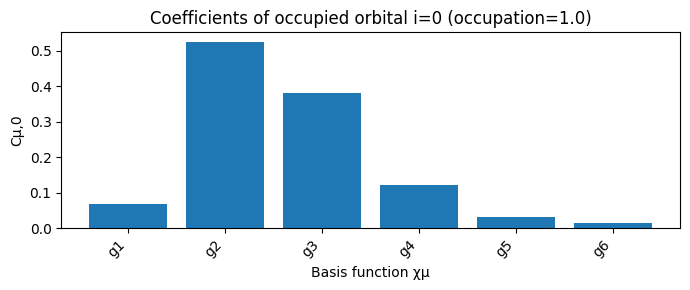

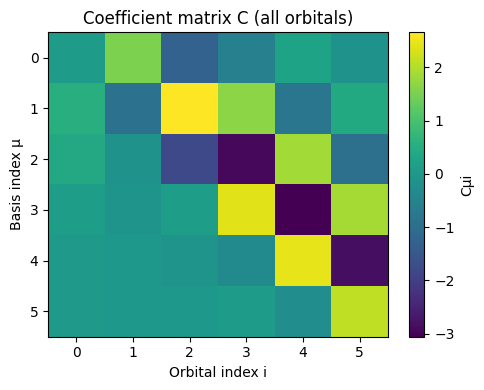

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def occupations_closed_shell(N_e, n_orbitals):
    """Closed-shell occupations for spatial orbitals."""
    occ = [0.0] * n_orbitals
    remaining = int(N_e)
    i = 0
    while remaining > 0 and i < n_orbitals:
        if remaining >= 2:
            occ[i] = 2.0
            remaining -= 2
        else:
            occ[i] = 1.0
            remaining -= 1
        i += 1
    return occ

n_orb = len(basis)
N_e_H = 1
occ_H = occupations_closed_shell(N_e_H, n_orb)

print("Coefficient matrix C (n x n):")
print(C_core)

df_orb = pd.DataFrame({
    "orbital i": np.arange(n_orb),
    "eps_i (Ha)": eps_core,
    "occupation f_i": occ_H,
})
display(df_orb)

occupied = [i for i,f in enumerate(occ_H) if f > 0]
print("Occupied orbital indices:", occupied)

labels = [bf["label"] for bf in basis]

for i in occupied:
    plt.figure(figsize=(7, 3))
    plt.bar(labels, C_core[:, i])
    plt.xlabel("Basis function χμ")
    plt.ylabel(f"Cμ,{i}")
    plt.title(f"Coefficients of occupied orbital i={i} (occupation={occ_H[i]})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Optional: show all orbitals at once as an image
plt.figure(figsize=(5, 4))
plt.imshow(C_core, aspect="auto")
plt.colorbar(label="Cμi")
plt.xlabel("Orbital index i")
plt.ylabel("Basis index μ")
plt.title("Coefficient matrix C (all orbitals)")
plt.tight_layout()
plt.show()


---

# Part II — Helium Atom: Real SCF and LDA Exchange (LDA-x)

In Part I, Hydrogen was used to build the SCF machinery step by step and to discuss self-interaction.

In this part, we switch to **Helium (He)**:
- there are **two electrons**,
- the Hartree term becomes a **physical electron–electron interaction**,
- and self-consistency is now **physically necessary**, not only pedagogical.

We will add a simple **LDA exchange** potential (no correlation yet) and compare:
- **Hartree-only** SCF
- **Hartree + LDA-x** SCF


## Routine 09 — Helium: recall the problem and write the equations

Helium is a **two‑electron** atom ($Z=2$). In a Kohn–Sham / mean‑field formulation, the interacting system is replaced by an effective one‑particle problem:

$$
\mathbf{F}[n]\mathbf{C} = \mathbf{S}\mathbf{C}\boldsymbol{\varepsilon},
\qquad
\mathbf{F}[n] = \mathbf{h} + \mathbf{J}[\mathbf{P}] + \mathbf{V}_x[n].
$$

- $\mathbf{S}$ is the overlap matrix (basis non‑orthogonality).
- $\mathbf{h}$ is the one‑electron “core” matrix (kinetic + electron–nucleus attraction).
- $\mathbf{J}[\mathbf{P}]$ is the Hartree (Coulomb) matrix built from the density matrix $\mathbf{P}$.
- $\mathbf{V}_x[n]$ is the (LDA) exchange matrix built from the density $n(\mathbf r)$.

The goal of SCF is to find a density (equivalently a density matrix) that is consistent with the orbitals it produces.


### Python notation box — global objects used in Part II

**Equation → code mapping**
- basis functions $\{\chi_\mu\}$ → `basis_he`
- overlap matrix $\mathbf{S}$ → `S_he`
- core matrix $\mathbf{h}$ → `h_he`
- density matrix $\mathbf{P}$ → `P`
- Hartree matrix $\mathbf{J}[P]$ → `J`
- exchange matrix $\mathbf{V}_x[n]$ → `Vx`
- effective operator $\mathbf{F}$ → `F = h + J + Vx`

**Programming notes**
- All matrices are stored as NumPy arrays with shape `(nbasis, nbasis)`.


### Implementation note

The next routines introduce each term **once**, define the needed functions (only if they were not defined before), and then assemble them into the SCF loop.


## Routine 10 — One‑electron matrices: $\mathbf{S}$, $\mathbf{T}$, $\mathbf{V}^{\mathrm{ne}}$, and $\mathbf{h}$

We expand orbitals in a Gaussian basis:
$$
\phi_i(\mathbf r)=\sum_\mu C_{\mu i}\,\chi_\mu(\mathbf r).
$$

Matrix elements are basis projections of integral expressions:

- Overlap:
$$
S_{\mu\nu}=\langle\chi_\mu|\chi_\nu\rangle
$$

- Kinetic:
$$
T_{\mu\nu}=\left\langle\chi_\mu\left|-\frac12\nabla^2\right|\chi_\nu\right\rangle
$$

- Electron–nucleus attraction (Helium: $Z=2$):
$$
V^{\mathrm{ne}}_{\mu\nu}=\left\langle\chi_\mu\left|-\frac{Z}{r}\right|\chi_\nu\right\rangle
$$

Core one‑electron matrix:
$$
\mathbf{h}=\mathbf{T}+\mathbf{V}^{\mathrm{ne}}.
$$


### Python notation box — one‑electron matrices

**Equation → code mapping**
- $S_{\mu\nu}$ → `S_he[mu, nu]`
- $T_{\mu\nu}$ → `T_he[mu, nu]`
- $V^{\mathrm{ne}}_{\mu\nu}$ → `Vne_he[mu, nu]`
- $h_{\mu\nu}$ → `h_he[mu, nu] = T_he + Vne_he`

**Programming notes**
- `core_hamiltonian(basis, Z, C)` returns `(S, T, Vne, h)` by calling the analytic Gaussian-integral routines defined in Part I.


### Implementation: build $\mathbf{S}$ and $\mathbf{h}$ for Helium

The next cell:
1. sets $Z=2$,
2. defines a 6‑Gaussian basis centered at the origin,
3. builds `S_he, T_he, Vne_he, h_he`,
4. solves the *core* generalized eigenproblem `h_he C = S_he C eps` as an initial guess (orbitals only; no electron–electron terms yet).


In [ ]:
# Helium setup (Z=2) using the same 6-primitive basis style as Part I
Z_he = 2.0
ORIGIN = np.array([0.0, 0.0, 0.0])

# Keep the basis explicit here so this part is self-contained
exponents_he = [0.05, 0.15, 0.5, 1.5, 4.5, 13.5]
basis_he = primitive_basis_from_exponents(exponents_he, center=ORIGIN, label_prefix="He")

# One-electron matrices for Helium
S_he, T_he, Vne_he, h_he = core_hamiltonian(basis_he, Z=Z_he, C=ORIGIN)

# Core (one-electron) eigenproblem as an initial guess
eps_he_core, C_he_core = solve_generalized_eigenproblem(h_he, S_he)

print("Helium basis size:", len(basis_he))
print("Lowest core eigenvalue (not SCF):", float(eps_he_core[0]), "Ha")


## Routine 11 — Density matrix $\mathbf{P}$ and Hartree matrix $\mathbf{J}[\mathbf{P}]$

### Density matrix
For a closed‑shell atom, the lowest spatial orbital is doubly occupied (2 electrons).  
The density matrix in a non‑orthonormal basis is:
$$
P_{\mu\nu}=\sum_i f_i\,C_{\mu i}C_{\nu i},
\qquad
\text{(Helium: } f_0=2,\ f_{i>0}=0\text{).}
$$

Electron count check (non‑orthonormal basis):
$$
N_e = \mathrm{Tr}(\mathbf{P}\mathbf{S}).
$$

### Hartree matrix
Electron–electron Coulomb repulsion enters via the Hartree matrix:
$$
J_{\mu\nu}[\mathbf{P}] = \sum_{\lambda\sigma} P_{\lambda\sigma}(\mu\nu|\lambda\sigma),
$$
where $(\mu\nu|\lambda\sigma)$ are the electron‑repulsion integrals (ERIs).


### Python notation box — $\mathbf{P}$ and $\mathbf{J}$

**Equation → code mapping**
- occupations $f_i$ → `occupations_he`
- density matrix $P_{\mu\nu}$ → `P_he_core[mu, nu]`
- electron count $N_e=\mathrm{Tr}(PS)$ → `np.trace(P_he_core @ S_he)`
- ERIs $(\mu\nu|\lambda\sigma)$ → `eri_he[mu, nu, la, si]`
- Hartree matrix $J[P]$ → `J_he_core = coulomb_matrix(P_he_core, eri_he)`

**Programming notes**
- `np.outer(C[:, i], C[:, i])` builds the rank‑1 contribution of orbital `i` to $\mathbf{P}$.
- `np.einsum("ls,mnls->mn", P, eri)` performs the ERI contraction to build $\mathbf{J}$ efficiently.


### Implementation: build $P$ (closed shell), then build ERIs and $J[P]$

The next cells:
1. define `density_matrix_from_orbitals(...)`,
2. build `P_he_core` from the *core* orbitals,
3. define ERI helpers (`eri_ssss`, `basis_eri_tensor`) and `coulomb_matrix`,
4. compute `eri_he` and the Hartree matrix `J_he_core`.


In [ ]:
def density_matrix_from_orbitals(C, occupations):
    # P_{mu nu} = sum_i f_i * C_{mu i} * C_{nu i}
    nbf = C.shape[0]
    P = np.zeros((nbf, nbf), dtype=float)
    for i, occ in enumerate(occupations):
        if occ == 0.0:
            continue
        P += occ * np.outer(C[:, i], C[:, i])
    return P


# Closed-shell occupations for Helium (2 electrons in the lowest spatial orbital)
occupations_he = [2.0] + [0.0] * (len(basis_he) - 1)

P_he_core = density_matrix_from_orbitals(C_he_core, occupations_he)
Ne_trace = float(np.trace(P_he_core @ S_he))

print("Trace electron count Tr(P S):", Ne_trace)


In [ ]:
# Helper functions: ERI tensor and Coulomb (Hartree) matrix

def eri_ssss(alpha, beta, gamma, delta, A, B, C, D):
    """
    Primitive (s s | s s) electron-repulsion integral.

    Parameters
    ----------
    alpha, beta, gamma, delta : float
        Gaussian exponents.
    A, B, C, D : array-like shape (3,)
        Gaussian centers.

    Returns
    -------
    float
        (ab|cd) = ∬ g_a(r1) g_b(r1) (1/|r1-r2|) g_c(r2) g_d(r2) dr1 dr2
        including s-type normalizations.
    """
    A = np.asarray(A, dtype=float)
    B = np.asarray(B, dtype=float)
    C = np.asarray(C, dtype=float)
    D = np.asarray(D, dtype=float)

    p = alpha + beta
    q = gamma + delta

    P = (alpha * A + beta * B) / p
    Q = (gamma * C + delta * D) / q

    AB2 = np.dot(A - B, A - B)
    CD2 = np.dot(C - D, C - D)
    PQ2 = np.dot(P - Q, P - Q)

    Kab = np.exp(-alpha * beta / p * AB2)
    Kcd = np.exp(-gamma * delta / q * CD2)

    T = (p * q) / (p + q) * PQ2

    pref = 2.0 * (np.pi ** 2.5) / (p * q * np.sqrt(p + q))
    eri_val = pref * Kab * Kcd * boys0(T)

    # Include s-type normalization constants (consistent with the other primitive integrals)
    return (norm_s(alpha) * norm_s(beta) * norm_s(gamma) * norm_s(delta)) * eri_val


def basis_eri_tensor(basis):
    """
    Build the 4-index electron-repulsion integral (ERI) tensor in the AO basis:
        eri[mu, nu, la, si] = (mu nu | la si)

    Each basis function `basis[mu]` is a dictionary with:
      - "center": 3D NumPy array
      - "primitives": list of (alpha, coeff)

    The ERI is built by summing over primitive contributions:
        (mu nu | la si) = Σ_{p,q,r,s} d_{mu,p} d_{nu,q} d_{la,r} d_{si,s} (pq|rs)
    """
    nbf = len(basis)
    eri = np.zeros((nbf, nbf, nbf, nbf), dtype=float)

    for mu, bmu in enumerate(basis):
        A = bmu["center"]
        for nu, bnu in enumerate(basis):
            B = bnu["center"]
            for la, bla in enumerate(basis):
                Cc = bla["center"]
                for si, bsi in enumerate(basis):
                    Dd = bsi["center"]

                    val = 0.0
                    for (alpha, d1) in bmu["primitives"]:
                        for (beta, d2) in bnu["primitives"]:
                            for (gamma, d3) in bla["primitives"]:
                                for (delta, d4) in bsi["primitives"]:
                                    val += d1 * d2 * d3 * d4 * eri_ssss(alpha, beta, gamma, delta, A, B, Cc, Dd)

                    eri[mu, nu, la, si] = val

    return eri


def coulomb_matrix(P, eri):
    """
    Coulomb (Hartree) matrix from density matrix P and ERIs:
        J_{mu nu} = Σ_{la si} P_{la si} (mu nu | la si)
    """
    return np.einsum("ls,mnls->mn", P, eri, optimize=True)


In [ ]:
# Build ERIs and Hartree matrix for the current density
eri_he = basis_eri_tensor(basis_he)
J_he_core = coulomb_matrix(P_he_core, eri_he)

print("ERI tensor shape:", eri_he.shape)
print("Hartree matrix shape:", J_he_core.shape)


## Routine 12 — LDA exchange: $E_x[n]$, $\varepsilon_x(n)$, $v_x(n)$, and $\mathbf{V}_x$

In LDA, exchange is modeled using the uniform electron gas:

$$
E_x[n] = \int n(\mathbf r)\,\varepsilon_x(n(\mathbf r))\,d^3r.
$$

For the spin‑unpolarized electron gas:
$$
\varepsilon_x(n) = -\frac{3}{4}\left(\frac{3}{\pi}\right)^{1/3} n^{1/3}.
$$

The exchange **potential** used in the operator is the functional derivative:
$$
v_x(\mathbf r)=\frac{\delta E_x[n]}{\delta n(\mathbf r)}
= \varepsilon_x(n) + n\,\frac{d\varepsilon_x}{dn}.
$$

This gives:
$$
v_x(n) = -\left(\frac{3}{\pi}\right)^{1/3} n^{1/3}.
$$

The matrix representation of this local potential is a projection:
$$
(V_x)_{\mu\nu}=\langle\chi_\mu|v_x[n]|\chi_\nu\rangle
= \int \chi_\mu(\mathbf r)\,v_x[n(\mathbf r)]\,\chi_\nu(\mathbf r)\,d^3r.
$$

For this atom-centered s‑type setup, the 3D integral becomes:
$$
(V_x)_{\mu\nu} = 4\pi\int_0^\infty r^2\,\chi_\mu(r)\,v_x[n(r)]\,\chi_\nu(r)\,dr.
$$


### Python notation box — LDA exchange objects

**Equation → code mapping**
- radial density $n(r)$ → `n_r`
- exchange energy per electron $\varepsilon_x(n)$ → `eps_x_r`
- exchange potential $v_x(n)$ → `v_x_r`
- exchange energy $E_x[n]$ → `Ex`
- exchange matrix $(V_x)_{\mu\nu}$ → `Vx`

**Programming notes**
- We evaluate $n(r)$ on a radial grid and use `np.trapezoid` for numerical integration.
- The matrix $V_x$ is built by integrating the kernel $r^2\chi_\mu(r)v_x(r)\chi_\nu(r)$ for each `(mu, nu)`.


### Implementation: build $n(r)$, then compute $E_x$ and $\mathbf{V}_x$

The next cells:
1. define radial helper functions and LDA‑x formulas,
2. compute `n_r` from `P_he_core`,
3. compute `Ex_he_core` and the exchange matrix `Vx_he_core`.


In [ ]:
def basis_values_on_radial_grid(basis, r_grid):
    """
    Return phi_grid[mu, k] = chi_mu(r_k) for s-type basis functions.
    Since all basis functions are centered at the origin and are s-like,
    the value depends only on r = |r|.
    """
    r_grid = np.asarray(r_grid, dtype=float)
    phi_grid = np.zeros((len(basis), len(r_grid)), dtype=float)
    for mu in range(len(basis)):
        phi_grid[mu, :] = basis_function_value(basis[mu], r_grid)
    return phi_grid

def radial_density_from_P(P, phi_grid):
    """
    Build spherical density n(r) from the basis density matrix P.
    n(r_k) = sum_{mu,nu} P_{mu,nu} chi_mu(r_k) chi_nu(r_k)
    """
    n_r = np.einsum("mn,mr,nr->r", P, phi_grid, phi_grid)
    # Numerical safety against tiny negative values from roundoff
    return np.clip(n_r, 0.0, None)

def electron_count_from_radial_density(r_grid, n_r):
    """
    N_e = 4*pi * integral r^2 n(r) dr
    """
    return float(4.0 * np.pi * np.trapezoid((r_grid**2) * n_r, r_grid))

def lda_x_eps_vx_spin_unpolarized(n_r):
    """
    LDA exchange for spin-unpolarized density.
      eps_x(n) = -(3/4)*(3/pi)^(1/3) * n^(1/3)
      v_x(n)   = -(3/pi)^(1/3) * n^(1/3)
    Returns:
      eps_x_r, v_x_r
    """
    n_r = np.clip(np.asarray(n_r, dtype=float), 1e-18, None)
    c_x = (3.0 / np.pi) ** (1.0 / 3.0)
    eps_x = -(3.0 / 4.0) * c_x * n_r ** (1.0 / 3.0)
    v_x = -c_x * n_r ** (1.0 / 3.0)
    return eps_x, v_x

def lda_x_energy_from_density(r_grid, n_r):
    """
    E_x[n] = 4*pi * integral r^2 n(r) eps_x(n(r)) dr
    """
    eps_x_r, _ = lda_x_eps_vx_spin_unpolarized(n_r)
    integrand = (r_grid**2) * n_r * eps_x_r
    return float(4.0 * np.pi * np.trapezoid(integrand, r_grid))

def vxc_matrix_from_local_potential_radial(basis, r_grid, v_local_r, phi_grid=None):
    """
    Build a local-potential matrix:
      V_{mu,nu} = 4*pi * integral r^2 chi_mu(r) v(r) chi_nu(r) dr
    """
    r_grid = np.asarray(r_grid, dtype=float)
    v_local_r = np.asarray(v_local_r, dtype=float)
    if phi_grid is None:
        phi_grid = basis_values_on_radial_grid(basis, r_grid)

    nbf = len(basis)
    Vmat = np.zeros((nbf, nbf), dtype=float)

    for mu in range(nbf):
        for nu in range(nbf):
            integrand = (r_grid**2) * phi_grid[mu, :] * v_local_r * phi_grid[nu, :]
            Vmat[mu, nu] = 4.0 * np.pi * np.trapezoid(integrand, r_grid)
    return Vmat


In [ ]:
# Build density and exchange objects for the current density matrix (core guess)
r_grid_he = np.linspace(0.0, 12.0, 1200)

phi_grid_he = basis_values_on_radial_grid(basis_he, r_grid_he)
n_he_core = radial_density_from_P(P_he_core, phi_grid_he)

eps_x_r, v_x_r = lda_x_eps_vx_spin_unpolarized(n_he_core)

Ex_he_core = lda_x_energy_from_density(r_grid_he, n_he_core)
Vx_he_core = vxc_matrix_from_local_potential_radial(
    basis_he, r_grid_he, v_x_r, phi_grid=phi_grid_he
)

print("Radial electron count (from n(r)):", electron_count_from_radial_density(r_grid_he, n_he_core))
print("Exchange energy Ex (core density):", Ex_he_core, "Ha")


## Routine 13 — Total energy in matrix form (why traces appear)

Once expanded in a basis, integral expressions become **matrix contractions**.

### One-electron term
$$
E_\mathrm{one}=\sum_i f_i\langle\phi_i|\hat h|\phi_i\rangle
\quad\Rightarrow\quad
E_\mathrm{one}=\mathrm{Tr}(\mathbf{P}\mathbf{h}).
$$

### Hartree term
The $\tfrac12$ avoids double counting electron pairs:
$$
E_H=\frac12\,\mathrm{Tr}(\mathbf{P}\mathbf{J}).
$$

### Exchange term
Exchange energy is the **functional** definition:
$$
E_x[n]=\int n(\mathbf r)\,\varepsilon_x(n(\mathbf r))\,d^3r,
$$
and is not equal to $\mathrm{Tr}(\mathbf{P}\mathbf{V}_x)$ because $\mathbf{V}_x$ comes from the functional derivative $v_x=\delta E_x/\delta n$.

### Total energy used in this notebook
$$
E_\mathrm{total} = \mathrm{Tr}(\mathbf{P}\mathbf{h})
+ \frac12\,\mathrm{Tr}(\mathbf{P}\mathbf{J})
+ E_x[n].
$$


### Python notation box — energy terms

**Equation → code mapping**
- $E_\mathrm{one}=\mathrm{Tr}(Ph)$ → `E_one = np.trace(P @ h)`
- $E_H=\tfrac12\mathrm{Tr}(PJ)$ → `E_H = 0.5 * np.trace(P @ J)`
- $E_x[n]$ → `Ex_he_core`
- $E_\mathrm{total}$ → `E_total`

**First-time functions (if new to students)**
- `np.trace(A)`: sum of diagonal elements (here used to implement $\mathrm{Tr}(\cdot)$).


### Implementation: compute the total energy for the current density

The next cell evaluates the energy terms for the current density matrix (core guess), using:
- `h_he`,
- `J_he_core`,
- `Ex_he_core`.


In [ ]:
E_one = float(np.trace(P_he_core @ h_he))
E_H   = float(0.5 * np.trace(P_he_core @ J_he_core))
E_total = E_one + E_H + Ex_he_core

print("E_one  = Tr(P h)        :", E_one, "Ha")
print("E_H    = 1/2 Tr(P J)    :", E_H, "Ha")
print("E_x    (LDA definition) :", Ex_he_core, "Ha")
print("E_total                :", E_total, "Ha")


## Routine 14 — SCF cycle (didactic step-by-step), then implementation

At iteration $k$, the SCF state is the density matrix $\mathbf{P}^{(k)}$.

### One iteration (what is computed first, next, and what is recomputed)

1. Compute $\mathbf{J}[\mathbf{P}^{(k)}]$ from ERIs  
2. Build $n^{(k)}(r)$ on the radial grid  
3. Compute $\varepsilon_x(n^{(k)})$ and $v_x(n^{(k)})$  
4. Build $\mathbf{V}_x[n^{(k)}]$ by projecting $v_x$ into the basis  
5. Assemble $\mathbf{F}^{(k)}=\mathbf{h}+\mathbf{J}+\mathbf{V}_x$  
6. Solve $\mathbf{F}^{(k)}\mathbf{C}=\mathbf{S}\mathbf{C}\boldsymbol{\varepsilon}$  
7. Build $\mathbf{P}^{(k+1)}_\mathrm{raw}$ from occupied orbitals  
8. Mix densities: $\mathbf{P}^{(k+1)}\leftarrow(1-\alpha)\mathbf{P}^{(k)}+\alpha\mathbf{P}^{(k+1)}_\mathrm{raw}$  
9. Recompute energy terms with the **mixed** density (for consistent reporting)  
10. Check convergence; repeat

The next cell implements this pipeline as a single reusable SCF function.


### Python notation box — SCF loop variables

**Equation → code mapping**
- current density matrix $\mathbf{P}^{(k)}$ → `P`
- Hartree matrix → `J = coulomb_matrix(P, eri)`
- radial density → `n_r = radial_density_from_P(P, phi_grid)`
- exchange matrix → `Vx = vxc_matrix_from_local_potential_radial(...)`
- effective operator → `F = h + J + Vx`
- mixed density → `P_new = (1-mixing)*P + mixing*P_raw`
- convergence → `np.linalg.norm(P_raw - P)` and energy change

**Programming notes**
- The function returns a dictionary with `history` (a Pandas table) plus final matrices and grids for plotting.


### Implementation: `scf_helium_gaussian_lda_x(...)`

The SCF driver below uses the exact sequence defined above and supports two modes:
- `mode="hartree_only"`: $\mathbf{F}=\mathbf{h}+\mathbf{J}$,
- `mode="lda_x"`: $\mathbf{F}=\mathbf{h}+\mathbf{J}+\mathbf{V}_x$.


In [ ]:
def scf_helium_gaussian_lda_x(
    basis,
    Z=2.0,
    mode="lda_x",              # "hartree_only" or "lda_x"
    rmax=12.0,
    ngrid=1200,
    mixing=0.35,
    max_iter=80,
    conv_tol=1e-10,
    verbose=True,
):
    """
    Minimal SCF for the He atom in an s-type Gaussian basis.
    Modes:
      - hartree_only : F = h + J
      - lda_x        : F = h + J + Vx[LDA]
    """
    # One-electron matrices and two-electron tensor
    S, T, Vne, h = core_hamiltonian(basis, Z=Z, C=ORIGIN)
    eri = basis_eri_tensor(basis)

    # Radial grid for density and local LDA-x matrix
    r_grid = np.linspace(0.0, float(rmax), int(ngrid))
    phi_grid = basis_values_on_radial_grid(basis, r_grid)

    nbf = len(basis)
    occupations = [2.0] + [0.0] * (nbf - 1)  # He closed shell

    # Initial guess from the core Hamiltonian
    eps, C = solve_generalized_eigenproblem(h, S)
    P = density_matrix_from_orbitals(C, occupations)

    history = []
    E_prev = None

    for it in range(1, max_iter + 1):
        # Density-dependent pieces
        J = coulomb_matrix(P, eri)
        n_r = radial_density_from_P(P, phi_grid)
        Ne_trace = float(np.trace(P @ S))
        Ne_grid = electron_count_from_radial_density(r_grid, n_r)

        if mode == "hartree_only":
            Vx = np.zeros_like(h)
            Ex = 0.0
        elif mode == "lda_x":
            eps_x_r, v_x_r = lda_x_eps_vx_spin_unpolarized(n_r)
            Vx = vxc_matrix_from_local_potential_radial(basis, r_grid, v_x_r, phi_grid=phi_grid)
            Ex = lda_x_energy_from_density(r_grid, n_r)
        else:
            raise ValueError("mode must be 'hartree_only' or 'lda_x'")

        # Effective one-particle operator
        F = h + J + Vx

        # Solve generalized eigenproblem and update density
        eps, C = solve_generalized_eigenproblem(F, S)
        P_raw = density_matrix_from_orbitals(C, occupations)

        dP = float(np.linalg.norm(P_raw - P))
        P_new = (1.0 - mixing) * P + mixing * P_raw

        # Energy monitoring (using the mixed density P_new and its functional terms)
        J_new = coulomb_matrix(P_new, eri)
        n_r_new = radial_density_from_P(P_new, phi_grid)

        if mode == "lda_x":
            Ex_new = lda_x_energy_from_density(r_grid, n_r_new)
        else:
            Ex_new = 0.0

        E_one = float(np.trace(P_new @ h))
        E_H = float(0.5 * np.trace(P_new @ J_new))
        E_total = E_one + E_H + Ex_new

        dE = np.nan if E_prev is None else float(E_total - E_prev)
        E_prev = E_total

        history.append({
            "iter": it,
            "E_total": E_total,
            "E_one": E_one,
            "E_H": E_H,
            "E_x": Ex_new,
            "dE": dE,
            "||dP||": dP,
            "Ne_trace": float(np.trace(P_new @ S)),
            "Ne_grid": electron_count_from_radial_density(r_grid, n_r_new),
            "eps0": float(eps[0]),
        })

        if verbose:
            dE_str = "nan" if np.isnan(dE) else f"{dE:+.3e}"
            print(
                f"[{mode}] iter {it:02d} | "
                f"E={E_total:+.10f} Ha | dE={dE_str} | "
                f"||dP||={dP:.3e} | Ne={history[-1]['Ne_trace']:.6f}"
            )

        P = P_new

        if (dP < conv_tol) and (not np.isnan(dE)) and (abs(dE) < conv_tol):
            break

    # Final derived quantities for output
    n_r_final = radial_density_from_P(P, phi_grid)
    J_final = coulomb_matrix(P, eri)

    if mode == "lda_x":
        _, v_x_final = lda_x_eps_vx_spin_unpolarized(n_r_final)
        Vx_final = vxc_matrix_from_local_potential_radial(basis, r_grid, v_x_final, phi_grid=phi_grid)
        Ex_final = lda_x_energy_from_density(r_grid, n_r_final)
    else:
        v_x_final = np.zeros_like(n_r_final)
        Vx_final = np.zeros_like(h)
        Ex_final = 0.0

    F_final = h + J_final + Vx_final
    eps_final, C_final = solve_generalized_eigenproblem(F_final, S)

    return {
        "S": S, "T": T, "Vne": Vne, "h": h, "eri": eri,
        "P": P, "F": F_final, "J": J_final, "Vx": Vx_final,
        "eps": eps_final, "C": C_final,
        "r_grid": r_grid, "phi_grid": phi_grid, "n_r": n_r_final, "v_x_r": v_x_final,
        "history": pd.DataFrame(history),
        "mode": mode, "Z": Z,
        "E_total_final": float(history[-1]["E_total"]),
        "E_x_final": Ex_final,
    }


## Routine 15 — Run Helium SCF: Hartree-only vs Hartree + LDA-x

We now run the same SCF workflow in two modes:

- **Hartree-only** (baseline, missing exchange)
- **LDA-x** (includes local exchange, no correlation yet)

This gives a concrete example of how an exchange-correlation potential is defined and inserted into the self-consistent cycle.


### Python notation box — running and comparing two SCF calculations

**Equation → code mapping**
- run mode → `mode="hartree_only"` or `mode="lda_x"`
- SCF settings → `he_scf_settings = dict(...)`
- pass settings into a function → `scf(..., **he_scf_settings)`

**Programming notes**
- `dict(...)` creates a dictionary of parameters (clean way to reuse settings).
- `**he_scf_settings` *unpacks* the dictionary into keyword arguments.
- Results are returned as dictionaries; `res["history"]` is a `pandas.DataFrame` used for inspection.

**First-time functions mentioned here**
- `display(df.tail())`: shows the last rows of a table (quick convergence check in a notebook).


### Implementation: run two SCF calculations and compare

**What the code does**
- runs the same SCF driver twice with different physics:
  - `mode="hartree_only"`
  - `mode="lda_x"`
- prints convergence tables and final energies for side-by-side comparison.


In [ ]:

# SCF run settings for He
he_scf_settings = dict(
    mixing=0.35,
    max_iter=80,
    conv_tol=1e-10,
    rmax=12.0,
    ngrid=1200,
)

res_he_hartree = scf_helium_gaussian_lda_x(
    basis_he, Z=Z_he, mode="hartree_only", verbose=True, **he_scf_settings
)

print("\n" + "=" * 80 + "\n")

res_he_ldax = scf_helium_gaussian_lda_x(
    basis_he, Z=Z_he, mode="lda_x", verbose=True, **he_scf_settings
)

hist_he_h = res_he_hartree["history"].copy()
hist_he_x = res_he_ldax["history"].copy()

display(hist_he_h.tail())
display(hist_he_x.tail())

print("\nFinal He energies (same basis, same SCF settings):")
print("Hartree-only :", res_he_hartree["E_total_final"], "Ha")
print("Hartree + LDA-x:", res_he_ldax["E_total_final"], "Ha")
print("Reference exact nonrelativistic He (for context): ~ -2.9037 Ha")


## Routine 16 — Visualize SCF convergence and final fields

This final Helium section compares:
- SCF convergence history,
- final radial densities,
- and the LDA exchange potential $v_x(r)$.

The goal is to make the **physics of the density-dependent operator** visible in the notebook.


### Python notation box — plotting convergence and physical observables

**Equation → code mapping**
- density $n(r)$ → `res["n_r"]`
- exchange potential $v_x(r)$ → `res["v_x_r"]`
- SCF convergence metric → `history["||dP||"]`

**Programming notes**
- `plt.semilogy(x, y)` plots on a logarithmic y-axis (useful for convergence curves).
- Multiple `plt.figure()` calls keep plots separate and readable.
- `plt.plot(...)` is used for densities/potentials on the radial grid.

**First-time functions mentioned here**
- `plt.semilogy(...)`: semilog plot (linear x, logarithmic y).


### Implementation: convergence and final-field plots

**What the code does**
- plots total energy and $||\Delta P||$ vs iteration,
- plots the final radial density $n(r)$ and LDA exchange potential $v_x(r)$.


In [ ]:

plt.figure()
plt.plot(hist_he_h["iter"], hist_he_h["E_total"], marker="o", label="He Hartree-only")
plt.plot(hist_he_x["iter"], hist_he_x["E_total"], marker="o", label="He Hartree + LDA-x")
plt.xlabel("SCF iteration")
plt.ylabel("Total energy (Hartree)")
plt.title("Helium SCF convergence")
plt.legend()
plt.show()

plt.figure()
plt.semilogy(hist_he_h["iter"], np.abs(hist_he_h["||dP||"]), marker="o", label="He Hartree-only")
plt.semilogy(hist_he_x["iter"], np.abs(hist_he_x["||dP||"]), marker="o", label="He Hartree + LDA-x")
plt.xlabel("SCF iteration")
plt.ylabel(r"$||\Delta P||$")
plt.title("Helium SCF density-matrix convergence")
plt.legend()
plt.show()

plt.figure()
plt.plot(res_he_hartree["r_grid"], res_he_hartree["n_r"], label="He density (Hartree-only)")
plt.plot(res_he_ldax["r_grid"], res_he_ldax["n_r"], label="He density (Hartree + LDA-x)")
plt.xlabel("r (bohr)")
plt.ylabel(r"$n(r)$")
plt.title("Final Helium radial density")
plt.legend()
plt.show()

plt.figure()
plt.plot(res_he_ldax["r_grid"], res_he_ldax["v_x_r"])
plt.xlabel("r (bohr)")
plt.ylabel(r"$v_x(r)$")
plt.title("Helium LDA exchange potential (final SCF density)")
plt.show()

print("Electron count checks (trace and radial grid):")
print("Hartree-only    :", hist_he_h.iloc[-1][['Ne_trace','Ne_grid']].to_dict())
print("Hartree + LDA-x :", hist_he_x.iloc[-1][['Ne_trace','Ne_grid']].to_dict())


### Interpreting the Helium results

- **Hartree-only** includes the classical Coulomb repulsion but **misses exchange**, so it is a useful baseline but not a good final electronic-structure model.
- **Hartree + LDA-x** adds a local exchange potential built from the density, improving the effective operator in a DFT-like way.
- The final Helium energy is still approximate because:
  1. the basis is finite,
  2. correlation is not included,
  3. only exchange (LDA-x) is used.

Even so, this part of the notebook shows the complete workflow for **defining and inserting an exchange-correlation ingredient into an SCF code**.
